# View-based representation of a Surface Function

## 

In [1]:
from numpy import load
import numpy as np
import matplotlib.pyplot as plt

import os

# Check the path
path = os.getcwd()
print("Current Working Directory ", path)

Current Working Directory  /media/camsz/SSD_Main/NeuS


In [2]:
data_path = os.path.join(path, 'data', 'DTU', 'scan83')
print(data_path)

cameras = load(os.path.join(data_path, 'cameras.npz'))
print(cameras.files)

/media/camsz/SSD_Main/NeuS/data/DTU/scan83
['scale_mat_0', 'scale_mat_inv_0', 'world_mat_0', 'world_mat_inv_0', 'camera_mat_0', 'camera_mat_inv_0', 'scale_mat_1', 'scale_mat_inv_1', 'world_mat_1', 'world_mat_inv_1', 'camera_mat_1', 'camera_mat_inv_1', 'scale_mat_2', 'scale_mat_inv_2', 'world_mat_2', 'world_mat_inv_2', 'camera_mat_2', 'camera_mat_inv_2', 'scale_mat_3', 'scale_mat_inv_3', 'world_mat_3', 'world_mat_inv_3', 'camera_mat_3', 'camera_mat_inv_3', 'scale_mat_4', 'scale_mat_inv_4', 'world_mat_4', 'world_mat_inv_4', 'camera_mat_4', 'camera_mat_inv_4', 'scale_mat_5', 'scale_mat_inv_5', 'world_mat_5', 'world_mat_inv_5', 'camera_mat_5', 'camera_mat_inv_5', 'scale_mat_6', 'scale_mat_inv_6', 'world_mat_6', 'world_mat_inv_6', 'camera_mat_6', 'camera_mat_inv_6', 'scale_mat_7', 'scale_mat_inv_7', 'world_mat_7', 'world_mat_inv_7', 'camera_mat_7', 'camera_mat_inv_7', 'scale_mat_8', 'scale_mat_inv_8', 'world_mat_8', 'world_mat_inv_8', 'camera_mat_8', 'camera_mat_inv_8', 'scale_mat_9', 'scal

### Camera transformations

In [3]:
from models.dataset import load_K_Rt_from_P

In [4]:
world_mat, scale_mat = cameras['world_mat_10'], cameras['scale_mat_10']
P = world_mat @ scale_mat
P = P[:3, :4]
intrisic, pose = load_K_Rt_from_P(None, P)
print('Intrisic matrix :\n', intrisic)
print('Pose matrix :\n', pose)

R = pose[:3, :3]
t = pose[:3, 3].reshape(3, 1)
print('R :\n', R)
print('t :\n', t)

Intrisic matrix :
 [[ 2.89233105e+03 -1.37212002e-04  8.23204712e+02  0.00000000e+00]
 [ 0.00000000e+00  2.88317554e+03  6.19071533e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Pose matrix :
 [[ 0.8850516   0.22057498 -0.40991506  1.4322033 ]
 [-0.3079622   0.93779767 -0.16029602  0.4347073 ]
 [ 0.3490601   0.26810858  0.89792806 -2.4807255 ]
 [ 0.          0.          0.          1.        ]]
R :
 [[ 0.8850516   0.22057498 -0.40991506]
 [-0.3079622   0.93779767 -0.16029602]
 [ 0.3490601   0.26810858  0.89792806]]
t :
 [[ 1.4322033]
 [ 0.4347073]
 [-2.4807255]]


In [5]:
# Geometric transformation
def h(x, P) :
    x = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
    return P @ x.T

def g(x_hat) :
    x_hat [:2, :] = x_hat[:2, :] / x_hat[2, :]
    return x_hat

def f(x, P) :
    return g(h(x, P)).T

In [6]:
x = np.array([[0, 0, 1], [1, 0, 0]])
print('x shape : ', x.shape)
x_hat = h(x, P)
print('x_hat :\n', x_hat)
print('u_hat :\n', g(x_hat))

x shape :  (2, 3)
x_hat :
 [[8.14494094e+05 9.29699312e+05]
 [7.16532625e+05 4.86265297e+05]
 [9.19955322e+02 6.01845306e+02]]
u_hat :
 [[ 885.36266277 1544.74796533]
 [ 778.87763423  807.95728023]
 [ 919.95532227  601.8453064 ]]


### Loading SDF/PDF

In [7]:
# load custom sdf network for scan 83
import torch
from models.fields import SDFNetwork

config = {
    'd_out': 257,
    'd_in': 3,
    'd_hidden': 128,  # 256
    'n_layers': 8,  # 8
    'skip_in': [4],  # [4]
    'multires': 6,
    'bias': 0.5,
    'scale': 1.0,
    'geometric_init': True,
    'weight_norm': True
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_exp_dir = 'exp/DTU/scan83/32_32_16_small_lowBS'
checkpoint_name = 'ckpt_150000.pth'
checkpoint = torch.load(os.path.join(base_exp_dir, 'checkpoints', checkpoint_name), map_location=device)

sdf_network = SDFNetwork(**config).to(device)
sdf_network.load_state_dict(checkpoint['sdf_network_fine'])

/tmp/ipykernel_78638/3171436062.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(base_exp_dir, 'checkpoints', checkpoint_name), map_

<All keys matched successfully>

### World and camera grids

In [10]:
limX = 1
R = 32
F = 2

grid_Xx = torch.linspace(-limX, limX, R * F)
grid_Xy = torch.linspace(-limX, limX, R * F)
grid_Xz = torch.linspace(-limX, limX, R * F)

grid_Xx, grid_Xy, grid_Xz = torch.meshgrid(grid_Xx, grid_Xy, grid_Xz)
grid_Xx = grid_Xx.reshape(-1, 1)
grid_Xy = grid_Xy.reshape(-1, 1)
grid_Xz = grid_Xz.reshape(-1, 1)

points = torch.cat([grid_Xx, grid_Xy, grid_Xz], dim=1)

points = points.to(device)

sdf_values = sdf_network.sdf(points)

In [12]:
def Phi(o, s) :
    return s * torch.exp(-s * o) / (1 + torch.exp(-s * o)) 

pdf = Phi(sdf_values, 1)
pdf = pdf.detach().unsqueeze(0).cpu().numpy().squeeze(-1)

In [13]:
grid_Ux_van = np.linspace(0, 1600, R)
grid_Uy_van = np.linspace(0, 1200, R)

distancex = 0.5 * (grid_Ux_van[1] - grid_Ux_van[0])
distancey = 0.5 * (grid_Uy_van[1] - grid_Uy_van[0])

grid_Ux_van, grid_Uy_van = np.meshgrid(grid_Ux_van, grid_Uy_van)
grid_Ux_van = grid_Ux_van.reshape(-1, 1)
grid_Uy_van = grid_Uy_van.reshape(-1, 1)

In [14]:
grid_fXx_van, grid_fXy_van, grid_fXz_van = np.array(f(points.cpu(), P).T)

In [15]:
import numpy as np
from time import time

print('Shape of Xx : ', grid_fXx_van.shape)
print('Shape of Ux : ', grid_Ux_van.shape)

Ux_min_van = grid_Ux_van - distancex
Ux_max_van = grid_Ux_van + distancex
Uy_min_van = grid_Uy_van - distancey
Uy_max_van = grid_Uy_van + distancey

now = time()
UXx_intersect_van = (grid_fXx_van < Ux_max_van) & (grid_fXx_van > Ux_min_van) & (grid_fXx_van > 0)
UXy_intersect_van = (grid_fXy_van < Uy_max_van) & (grid_fXy_van > Uy_min_van) & (grid_fXy_van > 0)
weights = np.zeros((R * R, 1))

mask_van = UXx_intersect_van & UXy_intersect_van
print('Shape of mask : ', mask_van.shape)
print(f'Time to compute mask : {time() - now:.2f} s')

# Sum the pdf values where the mask is True
now = time()
weights = np.sum(pdf * mask_van, axis=1, keepdims=True)
print(f'Time to compute weights : {time() - now:.2f} s')

Shape of Xx :  (262144,)
Shape of Ux :  (1024, 1)
Shape of mask :  (1024, 262144)
Time to compute mask : 0.23 s
Time to compute weights : 0.12 s


In [18]:
import PIL
import matplotlib.pyplot as plt
import numpy as np

Shape pdf : torch.Size([1, 262144]), shape mask : torch.Size([1024, 262144]), shape weights : torch.Size([1024, 1])


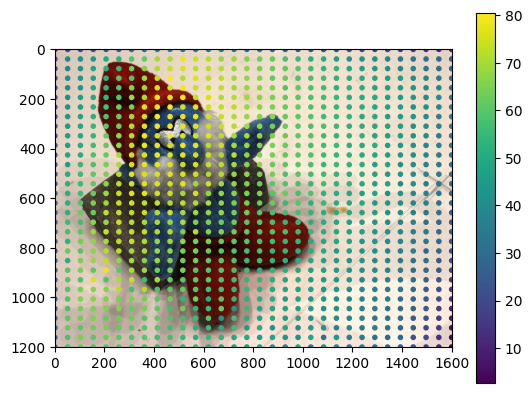

In [19]:
image = PIL.Image.open('data/DTU/scan83/image/000010.png')
image = np.array(image)

u = np.concatenate([grid_Ux_van, grid_Uy_van], axis=1)
u = u.reshape(-1, 2)
probs = compute_map(world_mat, scale_mat, 32, 32, 32, 2, 1600, 1200, 1)

plt.imshow(image)
plt.scatter(u[:, 0], u[:, 1], marker='.', c=probs)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.colorbar()

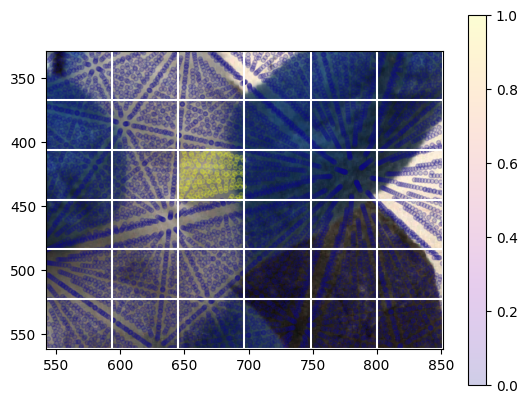

In [54]:
Ux_center = np.linspace(0, 1600, R)[11:17]
Uy_center = np.linspace(0, 1200, R)[9:15]

distancex = 0.5 * (Ux_center[1] - Ux_center[0])
distancey = 0.5 * (Uy_center[1] - Uy_center[0])
ux_min, ux_max = Ux_center.min() - distancex, Ux_center.max() + distancex
uy_min, uy_max = Uy_center.min() - distancey, Uy_center.max() + distancey
plt.imshow(image)

plt.vlines(Ux_center[:8] + distancex, uy_min, uy_max, colors='white')
plt.hlines(Uy_center[:8] + distancey, ux_min, ux_max, colors='white')

Ux_center, Uy_center = np.meshgrid(Ux_center, Uy_center)
Ux_center = Ux_center.reshape(-1, 1)
Uy_center = Uy_center.reshape(-1, 1)

x = np.concatenate([grid_Xx, grid_Xy, grid_Xz], axis=1)
u = f(x, P)
mask_crop = (u[:, 0] > ux_min) & (u[:, 0] < ux_max) & (u[:, 1] > uy_min) & (u[:, 1] < uy_max)
u = u[mask_crop]

# plt.scatter(Ux_center, Uy_center, c='r', marker='x')
# plt.scatter(u[:, 0], u[:, 1], c=pdf[mask], marker='x')


weights = np.zeros((len(Ux_center), 1))

Ux_min = Ux_center - distancex
Ux_max = Ux_center + distancex
Uy_min = Uy_center - distancey
Uy_max = Uy_center + distancey

UXx_intersect = ((grid_fXx_van < Ux_max) * (grid_fXx_van > Ux_min))
UXy_intersect = ((grid_fXy_van < Uy_max) * (grid_fXy_van > Uy_min))
mask = UXx_intersect * UXy_intersect

# for i, cell in enumerate(Ux_center) :
#     weights[i] = np.sum(pdf[mask[i]])
    
plt.scatter(u[:, 0], u[:, 1], c=mask[14][mask_crop], marker='.', cmap='plasma', alpha=0.2)

# plt.scatter(Ux_center, Uy_center, c=weights, cmap='viridis', s=60)

plt.xlim(ux_min, ux_max)
plt.ylim(uy_max, uy_min)
plt.colorbar()

### Global function (in the pipeline)

In [17]:
def compute_map(world_mat, scale_mat, Rx, Ry, Rz, F, W, H, s=1):
    
    # Define geometric transformation
    def h(x, P) :
        x = torch.concat([x, torch.ones((x.shape[0], 1))], axis=1)
        return P @ x.T

    def g(x_hat) :
        x_hat [:2, :] = x_hat[:2, :] / x_hat[2, :]
        return x_hat

    def f(x, P) :
        return g(h(x, P))
    
    # Define logistic function
    
    def Phi(o, s) :
        return s * torch.exp(-s * o) / (1 + torch.exp(-s * o)) 
    
    # Define projection matrix P
    P = torch.Tensor(world_mat @ scale_mat)[:3, :4]

    # Compute the grid of points in the world system
    grid_Xx = torch.linspace(-limX, limX, Rx * F)
    grid_Xy = torch.linspace(-limX, limX, Ry * F)
    grid_Xz = torch.linspace(-limX, limX, Rz * F)

    grid_Xx, grid_Xy, grid_Xz = torch.meshgrid(grid_Xx, grid_Xy, grid_Xz, indexing='xy')
    grid_Xx = grid_Xx.reshape(-1, 1)
    grid_Xy = grid_Xy.reshape(-1, 1)
    grid_Xz = grid_Xz.reshape(-1, 1)

    # Compute the grid of points in the camera system
    grid_Ux = torch.linspace(0, W, Rx)
    grid_Uy = torch.linspace(0, H, Ry)

    distancex = 0.5 * (grid_Ux[1] - grid_Ux[0])
    distancey = 0.5 * (grid_Uy[1] - grid_Uy[0])

    grid_Ux, grid_Uy = np.meshgrid(grid_Ux, grid_Uy, indexing='xy')
    grid_Ux = torch.from_numpy(grid_Ux.reshape(-1, 1))
    grid_Uy = torch.from_numpy(grid_Uy.reshape(-1, 1))
    
    # Compute the grid of points in the world-to-camera system
    points_world = torch.cat([grid_Xx, grid_Xy, grid_Xz], dim=1)
    grid_fXx, grid_fXy, grid_fXz = f(points_world, P)

    # Compute the PDF of world points
    with torch.no_grad():
        points_world = points_world.to(device)
        sdf_values = sdf_network.sdf(points_world)
        pdf_values = Phi(sdf_values, s)
        pdf_values = pdf_values.cpu().unsqueeze(0).squeeze(-1)
    
    # Compute the projected SDF in the camera system
    Ux_min = grid_Ux - distancex
    Ux_max = grid_Ux + distancex
    Uy_min = grid_Uy - distancey
    Uy_max = grid_Uy + distancey

    UXx_intersect = (grid_fXx < Ux_max) & (grid_fXx > Ux_min) & (grid_fXx > 0)
    UXy_intersect = (grid_fXy < Uy_max) & (grid_fXy > Uy_min) & (grid_fXy > 0)

    mask = UXx_intersect & UXy_intersect
    
    probs = torch.sum(pdf_values * mask, axis=1, keepdims=True).to('cpu')
    print(f'Shape pdf : {pdf_values.shape}, shape mask : {mask.shape}, shape weights : {probs.shape}')
    
    torch.cuda.empty_cache()
    
    return probs